In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import urllib.request as request
from urllib.parse import quote

import ruptures as rpt

from datetime import datetime
from datetime import timedelta
from tqdm import tqdm

In [204]:
def getMeterPoints(Customer):
    ApiKey = "3bb0bb5c-392d-4daa-8b0e-6a675387d08b"
    url = "https://superhub.dk/api/nrgiraadgivning/v2/meteringPoints"
    url = url + "?" + "apikey=" + ApiKey + "&customerKey=" + quote(Customer)
    #print(url)
    response = requests.get(url)
    df = pd.json_normalize(response.json()) 
    df['meteringPointId'] = pd.to_numeric(df['meteringPointId'])
    #print(df['meteringPointId'].to_list())
    IDs = df['meteringPointId'].to_list()
    return df, IDs

def getMeterReadings(meteringPoints):
    ApiKey = "3bb0bb5c-392d-4daa-8b0e-6a675387d08b"
    From = '31122021'#(datetime.today() - timedelta(days = 1000)).strftime('%d%m%Y')
    To = datetime.today().strftime('%d%m%Y')
    df = pd.DataFrame()
    Fails = 0
    for meter in tqdm(meteringPoints):
        url = "https://superhub.dk/api/nrgiraadgivning/v2/meterreadings"
        url = url + "?" + "apikey=" + ApiKey + "&meteringpointId=" + str(meter) + "&from=" + From + "&to=" + To
        
        response = requests.get(url)
        if response.status_code != 200:
            Fails += 1
            continue
        jso = response.json()

        dff = pd.json_normalize(jso)
        
        if (dff.columns == 'meteringPoints.Production').any():
            df_meter = pd.json_normalize(jso['meteringPoints'], 'Production')
        else:
            df_meter = pd.json_normalize(jso['meteringPoints'], 'Consumption') 
        df_meter['meter'] = jso['meteringPointId']
        df_meter['Adresse'] = jso['streetName'] + ' ' + jso['buildingNumber'] + ', ' + jso['postcode'] + ' ' + jso['cityName']
        df = pd.concat([df, df_meter], ignore_index=True)
    df['from'] = pd.to_datetime(df['from'], utc=True)
    df['meter'] = pd.to_numeric(df['meter'])
    print('Amount of fails: ' + str(Fails))
    return df

def get_day_moment(hour) -> str: 
    if 6 <= hour <= 18:
        return 'day'
    return 'night'

def ugeprofil(df):
            dff = df.groupby([df['from'].dt.day_name(locale='da_DK'), df['from'].dt.hour]).mean().reset_index(names=['day', 'hour'])
            dff['day_'] = dff['day']
            dff['day_'].replace({
                    "Mandag": 0,
                    "Tirsdag": 1,
                    "Onsdag": 2,
                    "Torsdag": 3,
                    "Fredag": 4,
                    "Lørdag": 5,
                    "Søndag": 6},
                    inplace=True,)
            dff.sort_values(['day_', 'hour'], ascending=True, inplace=True)
            dff['x-axis'] = dff.apply(lambda row: row['day'] + ' kl. ' + str(row['hour']), axis=1)
            return dff

def rupt(tid, df):
    nbkps = 12

    test = df['amount']
    points=np.array(test)
    n= len(points)
    if nbkps == 1:
        nbkps = np.floor(np.round(n/365*4))
    #Changepoint detection with dynamic programming search method
    model = "l1"  
    algo = rpt.Window(width=24*30, model=model, min_size=3, jump=5).fit(points)
    my_bkps = algo.predict(n_bkps=nbkps)
    return my_bkps

def besp():
    df_besp = pd.DataFrame(columns=['Adresse', 'besparelse', 'årligt forbrug', 'last', 'best', 'mean', 'bkps'])
    dfff = pd.DataFrame()
    
    for adr in tqdm(df['Adresse'].unique()):
        dff = df[df['Adresse']==adr]
        dff['day-moment'] = dff['from'].dt.hour.map(get_day_moment)
        dff = dff.groupby('from').agg({'meter': 'mean', 'amount': 'sum', 'day-moment': 'first', 'Adresse': 'first'}).reset_index()
        my_bkps = rupt('day', dff)

        value_avg_day = np.zeros(len(dff['amount']))
        #stdd_avg_day  = np.zeros(len(dff['amount']))
        vvvv = np.zeros((len(my_bkps),2),)
        k=0
        j=0
        for i in my_bkps:
            value_avg_day[j:i] = np.mean(dff['amount'][j:i])
            #stdd_avg_day[j:i]  = np.std(dff['amount'][j:i])
            vvvv[k, 0] = np.mean(dff['amount'][j:i])
            vvvv[k, 1] = i
            k += 1
            j=i
        dff['bkps'] = value_avg_day
        
        if dff['bkps'].iloc[-1] >= dff['bkps'].max():
            df_opti = dff[dff['bkps']==dff['bkps'].iloc[-1]].groupby('from').agg({'meter': 'mean', 'amount': 'sum', 'day-moment': 'first'}).reset_index()
        else:
            df_opti = dff[dff['bkps']==dff['bkps'].min()].groupby('from').agg({'meter': 'mean', 'amount': 'sum', 'day-moment': 'first'}).reset_index()

        df_norm = dff[dff['bkps']==dff['bkps'].iloc[-1]].groupby('from').agg({'meter': 'mean', 'amount': 'sum', 'day-moment': 'first'}).reset_index()

        uge = ugeprofil(df_opti)
        uge2 = ugeprofil(df_norm) 
        #print(my_bkps)

        ugg = uge[['day', 'hour', 'amount', 'x-axis']].merge(uge2[['day', 'hour', 'amount']], how='outer', on=['day', 'hour'], suffixes=('_opti', '_now'))
        ugg['besparelse_kwh'] = ugg['amount_now'] - ugg['amount_opti']
        ttt = pd.DataFrame(data={'Adresse': [adr], 
                                 'besparelse': [ugg['besparelse_kwh'].sum()*52], 
                                 'årligt forbrug': [ugg['amount_now'].sum()*52],
                                 'last': df_norm['amount'].mean(),
                                 'best': df_opti['amount'].mean(), 
                                 'mean': dff['amount'].mean(),
                                 'meter': dff['meter'].mean(),
                                 'bkps': 0,
                                 'bkps_value': 0,
                                 'total kwh': dff['amount'].sum()} )
        ttt[['bkps', 'bkps_value']] = ttt[['bkps', 'bkps_value']].astype('object')
        ttt.at[0,'bkps'] = my_bkps
        ttt.at[0,'bkps_value'] = vvvv[:,0]
        df_besp = df_besp.append(ttt)
        dfff = dfff.append(dff)

    df_besp = df_besp[df_besp['årligt forbrug'] != 0.0]
    df_besp['%'] = df_besp.apply(lambda row: row['besparelse']/row['årligt forbrug']*100, axis=1)
    return df_besp, dfff

In [208]:
kunde = 'FitnessWorld'
df, IDs = getMeterPoints(kunde)
print(IDs)
df.head()

[571313174113109854, 571313102301544422, 571313103103405935, 571313103190475996, 571313104200303681, 571313104402016525, 571313104402112487, 571313104402717996, 571313104601398026, 571313105100045114, 571313105100045138, 571313105200192749, 571313105200537151, 571313105200725541, 571313105200757962, 571313105200782599, 571313105200806677, 571313105200818205, 571313105202840747, 571313105290374575, 571313113150316283, 571313113160700836, 571313113161082863, 571313113161558368, 571313114400587163, 571313114400609858, 571313115101079025, 571313115101080458, 571313115101081363, 571313115101088683, 571313115101089888, 571313115101114160, 571313115101121687, 571313115101121915, 571313115101143368, 571313115101143382, 571313115101143399, 571313115101590858, 571313115101592326, 571313115103480898, 571313115104018328, 571313115104034496, 571313115104075734, 571313115104136978, 571313115104198433, 571313115104334671, 571313115190720327, 571313115200001514, 571313115200091324, 571313115200091348,

,meteringPointId,streetName,buildingNumber,postcode,cityName
0,571313174113109854,Vadstrupvej,35,2880,Bagsværd
1,571313102301544422,Torvet,11,9700,Brønderslev
2,571313103103405935,Frederikshavnsvej,79,9800,Hjørring
3,571313103190475996,Løvbakken,4G,9400,Nørresundby
4,571313104200303681,Storegade,6,7700,Thisted


In [201]:
df = getMeterReadings(IDs)

100%|██████████| 255/255 [02:16<00:00,  1.87it/s]


Amount of fails: 0


In [184]:
#df[df['Adresse']=='Vandmanden 5, 9200 Aalborg SV'].head()

In [202]:
df['day-moment'] = df['from'].dt.hour.map(get_day_moment)
#df.head()

In [205]:
df_besp, dff = besp()
dff['meter'] = pd.to_numeric(dff['meter'])


  0%|          | 0/188 [00:00<?, ?it/s]C:\Users\misc\AppData\Local\Temp\ipykernel_14036\4068178132.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['day-moment'] = dff['from'].dt.hour.map(get_day_moment)
C:\Users\misc\AppData\Local\Temp\ipykernel_14036\4068178132.py:49: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dff = df.groupby([df['from'].dt.day_name(locale='da_DK'), df['from'].dt.hour]).mean().reset_index(names=['day', 'hour'])
C:\Users\misc\AppData\Local\Temp\ipykernel_14036\4068178132.py:49: FutureWarning: The default value of numeric_only i

In [213]:
df_besp.to_csv('../Data/besp/'+kunde+'.csv', header=True, sep=',', index=False)
dff.to_csv('../Data/timeforbrug/'+kunde+'.csv', header=True, sep=',', index=False)

In [210]:
#dff.head()

In [211]:
#df_besp.head()

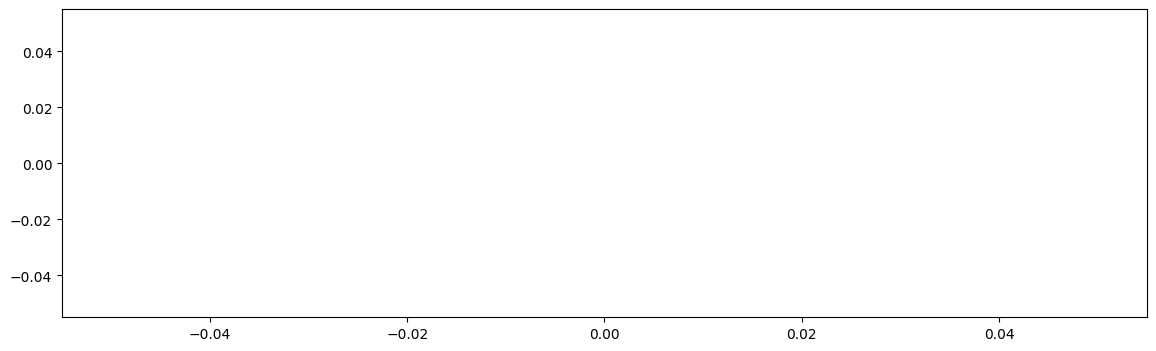

In [214]:
dfff = dff[dff['Adresse']=='Vandmanden 5, 9200 Aalborg SV'].groupby('from').agg({'meter': 'mean', 'amount': 'sum', 'bkps': 'sum'}).reset_index()

fig, ax = plt.subplots(figsize=(14,4)) 
ax.plot(dfff['from'], dfff['amount'], linewidth=0.3)
ax.plot(dfff['from'], dfff['bkps'])
ax.plot(dfff['from'][dfff['bkps']==dfff['bkps'].min()], dfff['bkps'][dfff['bkps']==dfff['bkps'].min()], linewidth=6)


In [148]:
dfff.head()

,from,meter,amount,bkps
